## Red neuronal Perceptrón multicapa  


In [1]:
#%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
tf.__version__

'2.3.1'

In [3]:
from tensorflow.keras.datasets.fashion_mnist import load_data
fashion_mnist = load_data()
#read_data_sets("exercice/data", one_hot = True)

## Separando el conjunto de datos en Entrenamiento y prueba 

In [4]:
(x_train, y_train), (x_test, y_test)=fashion_mnist

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
imagendemo=x_train[0,:,:]

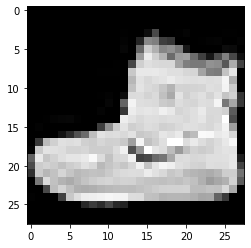

In [7]:
plt.imshow(imagendemo,cmap='gray')

Las etiquetas numéricas pueden ser transformadas al nombre de la clase correspondiente usando el siguiente diccionario 

In [8]:
label_dict = {
 0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"
}

In [9]:
label_dict[y_train[0]]

'Ankle boot'

In [10]:
x_train=x_train.reshape(-1,28*28).astype('float32')/255
x_test=x_test.reshape(-1,28*28).astype('float32')/255
x_train.shape

(60000, 784)

In [11]:
x_train.shape

(60000, 784)

Las salidas y deben se codificadas en one hot

In [12]:
# onehot encode
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

(60000, 10)

### Declarando la arquitectura

Generando función 

In [13]:
class DNN_model(object):
    def __init__(self,
                 n_nodes_hl1=500,
                 n_nodes_hl2=500,
                 n_nodes_hl3=500,
                 n_classes=10):
        self.h1LW = tf.Variable(np.random.randn(784, n_nodes_hl1),name="hl1weigths",dtype="float32")
        self.h1LB = tf.Variable(np.random.randn(n_nodes_hl1),name="hl1bias",dtype="float32")
        self.h2LW = tf.Variable(np.random.randn(n_nodes_hl1, n_nodes_hl2),name="hl2weigths",dtype="float32")
        self.h2LB = tf.Variable(np.random.randn(n_nodes_hl2),name="hl2bias",dtype="float32")
        self.h3LW = tf.Variable(np.random.randn(n_nodes_hl2, n_nodes_hl3),name="hl3weigths",dtype="float32")
        self.h3LB = tf.Variable(np.random.randn(n_nodes_hl3),name="hl3bias",dtype="float32")
        self.outW = tf.Variable(np.random.randn(n_nodes_hl3, n_classes),name="outweigths",dtype="float32")
        self.outB = tf.Variable(np.random.randn(n_classes),name="outbias",dtype="float32")
        self.trainable_variables =[self.h1LW,self.h1LB,self.h2LW,self.h2LB,self.h3LW,self.h3LB,self.outW,self.outB]          
    def __call__(self,x): 
        # Declarando la arquitectura

        l1 = tf.add(tf.matmul(x,self.h1LW), self.h1LB)
        l1 = tf.nn.relu(l1)

        l2 = tf.add(tf.matmul(l1,self.h2LW), self.h2LB)
        l2 = tf.nn.relu(l2)

        l3 = tf.add(tf.matmul(l2,self.h3LW), self.h3LB)
        l3 = tf.nn.relu(l3)

        output = tf.add(tf.matmul(l3,self.outW),self.outB)
        return output
  

In [14]:
DNN = DNN_model()
DNN(x_train[24:30])

<tf.Tensor: shape=(6, 10), dtype=float32, numpy=
array([[ -52733.266  ,    7753.1616 ,  -10880.492  ,  115901.07   ,
         -70552.94   ,   97217.03   ,  -70099.57   ,   22462.123  ,
          76632.45   ,  -16206.486  ],
       [ -22163.848  ,     363.61456,  -25753.879  ,   44497.457  ,
         -52355.047  ,   48610.734  ,  -56358.543  ,   -6185.933  ,
          79992.234  ,   10074.744  ],
       [ -29290.379  ,   76153.055  ,  -33143.81   ,   71710.41   ,
         -75714.28   ,   88279.3    , -137203.1    ,   35346.832  ,
          52936.62   ,   37374.516  ],
       [ -44881.977  ,   31174.078  ,  -21571.053  ,  177100.78   ,
         -91072.02   ,   92110.32   , -112662.23   ,   56604.438  ,
          69777.7    ,   47955.637  ],
       [ -40422.453  ,    8489.564  ,  -21179.104  ,  114281.55   ,
         -58269.395  ,   49327.65   ,  -57400.695  ,   11123.976  ,
          32102.422  ,    2487.6458 ],
       [ -45963.895  ,   11685.69   ,  -22049.475  ,  107690.484  ,
        

Seleccionar un optimizador 

In [15]:
#optimizador = tf.keras.optimizers.Adam(learning_rate=0.001 )
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

### Definir las metricas a usar

In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

### Calculo de gradientes y ajuste 

In [17]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata)
        #calculo de una funcion de error 
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( labels, predictions ))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [18]:
@tf.function
def test_step(model,tdata, labels):
    predictions = model(tdata)
    t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [19]:

class batch_loader:
    def __init__(self,data_x,data_y,batch_size=100):
        self.x=data_x
        self.y=data_y
        self.index=0
        self.len=len(data_x)
        self.batch_size=batch_size
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.len

    def __next__(self):
        if self.index+self.batch_size<=self.len:
            to_return=(self.x[self.index:self.index+self.batch_size,:],self.y[self.index:self.index+self.batch_size,:])
            self.index+=self.batch_size
            return to_return
        elif self.index<self.batch_size:
            to_return=(self.x[self.index:,:],self.y[self.index:,:])
            self.index=self.len
            return to_return
        else:
            raise StopIteration

## función de entrenamiento  y prueba

In [20]:

def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,batch_size=100):
    for epoch in range(EPOCHS):
        i=0
        for batch_x, batch_y in batch_loader(train_x,train_y,batch_size):
              train_step(model,batch_x,batch_y)

        test_step(model,test_x,test_y)

        template = 'Epoch {:02}, Perdida: {:.2f}, Exactitud: {:.2f}, Perdida de prueba: {:.2f}, Exactitud de prueba: {:.2f}'
        print(template.format(epoch+1,
                             train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

  
    

In [21]:
fitting(DNN,x_train,y_train_onehot,x_test,y_test_onehot,100,100)

Epoch 01, Perdida: 3808.97, Exactitud: 73.91, Perdida de prueba: 1955.91, Exactitud de prueba: 78.89
Epoch 02, Perdida: 1407.21, Exactitud: 80.96, Perdida de prueba: 1420.51, Exactitud de prueba: 80.76
Epoch 03, Perdida: 963.76, Exactitud: 83.07, Perdida de prueba: 1097.08, Exactitud de prueba: 82.41
Epoch 04, Perdida: 716.75, Exactitud: 84.50, Perdida de prueba: 952.80, Exactitud de prueba: 82.54
Epoch 05, Perdida: 570.51, Exactitud: 85.46, Perdida de prueba: 844.69, Exactitud de prueba: 83.46
Epoch 06, Perdida: 455.72, Exactitud: 86.64, Perdida de prueba: 823.83, Exactitud de prueba: 82.69
Epoch 07, Perdida: 393.64, Exactitud: 87.24, Perdida de prueba: 740.26, Exactitud de prueba: 83.79
Epoch 08, Perdida: 322.51, Exactitud: 88.19, Perdida de prueba: 724.75, Exactitud de prueba: 82.68
Epoch 09, Perdida: 277.75, Exactitud: 88.74, Perdida de prueba: 771.78, Exactitud de prueba: 82.61
Epoch 10, Perdida: 259.05, Exactitud: 89.06, Perdida de prueba: 671.53, Exactitud de prueba: 83.33
Epoch